In [ ]:
## Task 1a prediction using our model

In [2]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="surprise_task1.h5", repo_type="dataset", local_dir="data")
# hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="surprise_task2.h5", repo_type="dataset", local_dir="data")
# hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="surprise_task3.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="surprise_events1.csv", repo_type="dataset", local_dir="data")
# hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="surprise_events2.csv", repo_type="dataset", local_dir="data")
# hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="surprise_events3.csv", repo_type="dataset", local_dir="data")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


surprise_task1.h5:   0%|          | 0.00/43.1M [00:00<?, ?B/s]

surprise_events1.csv:   0%|          | 0.00/9.85k [00:00<?, ?B/s]

'data/surprise_events1.csv'

In [3]:
import pandas as pd
# example reading in the csv for surprise task 1
df = pd.read_csv("/content/data/surprise_events1.csv", parse_dates=["start_utc"])
print(f"Number of unique events: {len(df.id.unique())}")
df.head()

Number of unique events: 10


,id,img_type,start_utc,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,height_m,width_m
0,S844398,ir069,2019-07-29 19:49:00+00:00,33.568521,-99.143269,36.986895,-94.869356,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
1,S844398,ir107,2019-07-29 19:49:00+00:00,33.568521,-99.143269,36.986895,-94.869356,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
2,S844398,lght,NaT,33.568521,-99.143269,36.986895,-94.869356,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
3,S844398,vil,2019-07-29 19:50:00+00:00,33.568521,-99.143269,36.986895,-94.869356,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
4,S844398,vis,2019-07-29 19:49:00+00:00,33.568521,-99.143269,36.986895,-94.869356,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0


In [14]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import os
import h5py
from skimage.transform import resize
from tensorflow.keras.optimizers import Adam

# Load the trained model (without custom objects)
model = load_model("/content/deepunet3d_vil_192_model.h5", compile=False)

# Recompile the model with metrics defined explicitly
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Confirm model is reloaded and recompiled successfully
print("Model reloaded and recompiled successfully!")

# model = tf.keras.models.load_model("/content/deepunet3d_vil_192_model.h5")

# File paths
surprise_h5_path = "/content/data/surprise_task1.h5"

# Task 1A Storm IDs
task1_ids = ['S844398', 'S851491', 'S851111', 'S837416', 'S849444',
             'S843931', 'S858827', 'S856118', 'S849552', 'S854791']

def normalize(data):
    min_val, max_val = data.min(), data.max()
    if max_val - min_val == 0:
        return np.zeros_like(data)
    return (data - min_val) / (max_val - min_val)

def preprocess_event_data(h5_file_path, event_ids, input_frames=12, image_size=(128, 128)):
    X_dict = {}
    with h5py.File(h5_file_path, 'r') as f:
        for event_id in event_ids:
            if event_id in f and 'vil' in f[event_id]:
                vil = f[event_id]['vil'][:]  # Shape: (384, 384, 12)

                # Resize (384, 384) -> (128, 128)
                resized_vil = np.stack([resize(vil[:, :, t], image_size) for t in range(vil.shape[2])], axis=-1)

                normalized_vil = normalize(resized_vil)

                # (128, 128, 12, 1)
                X_dict[event_id] = np.expand_dims(normalized_vil, axis=-1)

    return X_dict

# Preprocess the surprise data
X_surprise = preprocess_event_data(surprise_h5_path, task1_ids)

# Predict and save
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

for event_id, X_input in X_surprise.items():
    X_input = np.expand_dims(X_input, axis=0)  # Shape: (1, 128, 128, 12, 1)

    y_pred = model.predict(X_input)  # Shape: (1, 128, 128, 12, 1)
    y_pred = np.squeeze(y_pred, axis=(0, -1))  # Shape: (128, 128, 12)

    # Resize back (128, 128) -> (384, 384)
    y_pred_resized = np.stack([resize(y_pred[:, :, t], (384, 384)) for t in range(y_pred.shape[2])], axis=-1)

    # Save .npy file
    output_filename = f"Alberto-task1a-vil-{event_id}.npy"
    output_path = os.path.join(output_dir, output_filename)
    np.save(output_path, y_pred_resized.astype(np.float32))

print("Prediction completed and saved!")


Model reloaded and recompiled successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step
Prediction completed and saved!


In [15]:
# choose one storm event (first)
storm_id = "S844398"
file_path = f"predictions/Alberto-task1a-vil-{storm_id}.npy"

# load .npy file
pred_vil = np.load(file_path)  # Shape: (384, 384, 12)

print(f"Loaded prediction shape: {pred_vil.shape}")


Loaded prediction shape: (384, 384, 12)


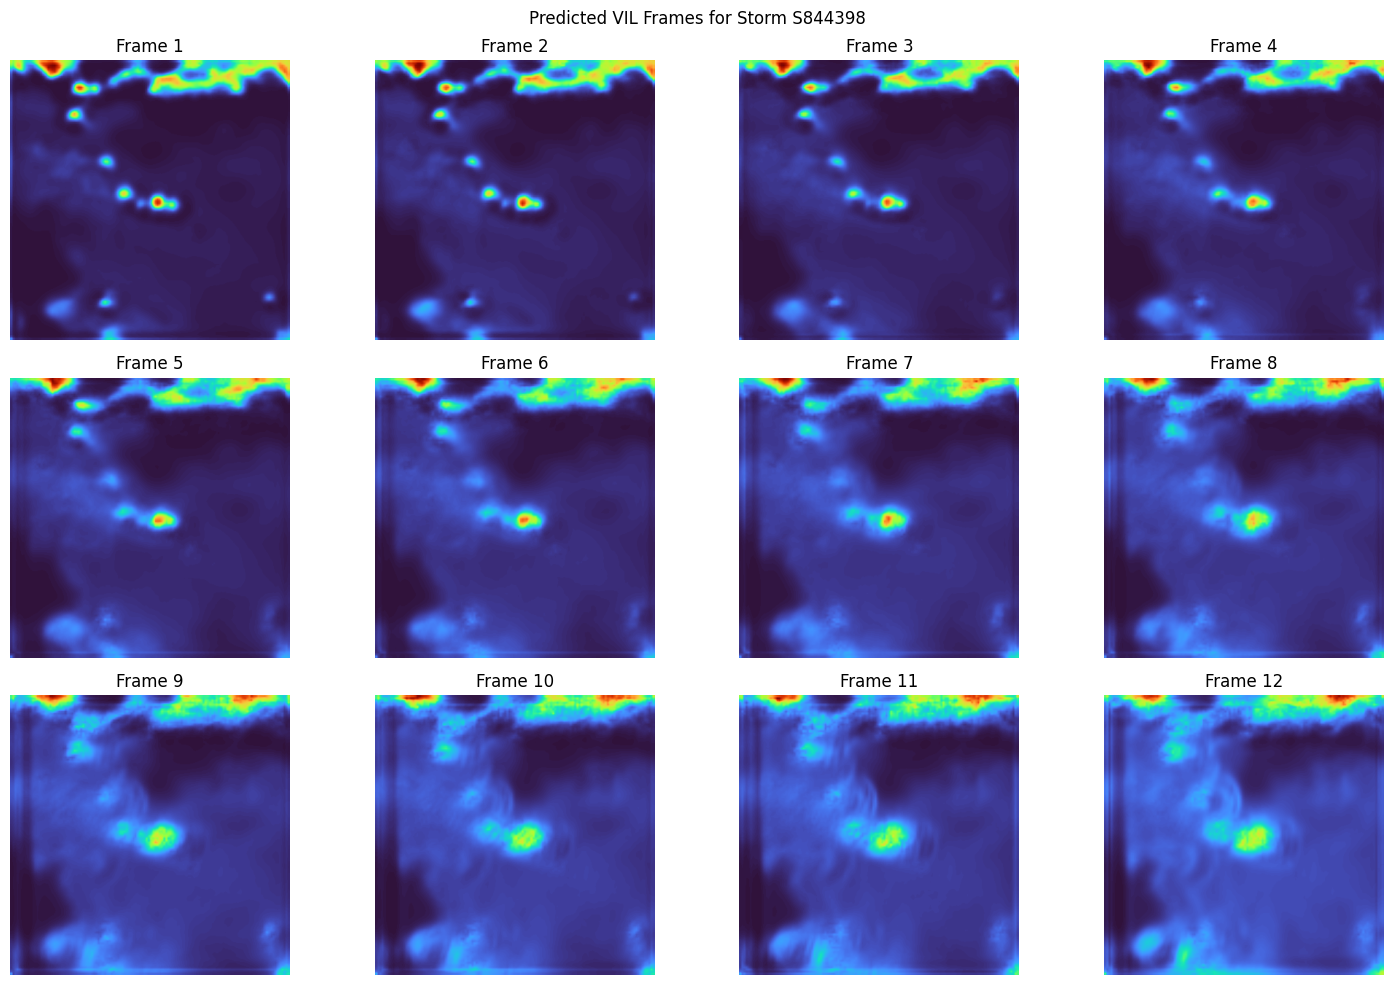

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(pred_vil[:, :, i], cmap='turbo')
    ax.set_title(f"Frame {i+1}")
    ax.axis("off")

plt.suptitle(f"Predicted VIL Frames for Storm {storm_id}")
plt.tight_layout()
plt.show()


### Task 1b Suprise data prediction

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import h5py
import pandas as pd
from skimage.transform import resize

# Load the trained model
model_path = "3dcnnunet_vil_128_model.h5"  # Change to your actual model path
model = load_model(model_path, compile=False)

# Recompile the model with an optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='mae', metrics=[tf.keras.metrics.MeanAbsoluteError()])

print("Model loaded and ready for prediction!")


Model loaded and ready for prediction!


In [6]:
# File paths
surprise_h5_path = "data/surprise_task1.h5"
surprise_csv_path = "data/surprise_events1.csv"

# Read the CSV file to get event IDs
df = pd.read_csv(surprise_csv_path)
surprise_event_ids = df["id"].unique().tolist()

print(f"Number of surprise storms: {len(surprise_event_ids)}")
print("Example event IDs:", surprise_event_ids[:5])

# Function to preprocess surprise storm data
def preprocess_surprise_data(h5_path, event_ids, modalities=["vis", "ir069", "ir107", "vil"], image_size=(128, 128)):
    """
    Load and preprocess multimodal surprise storm data.

    Args:
        h5_path (str): Path to the HDF5 surprise dataset.
        event_ids (list): List of event IDs.
        modalities (list): Data types to load.
        image_size (tuple): Target spatial size.

    Returns:
        dict: A dictionary of preprocessed event data.
    """
    X_dict = {}

    with h5py.File(h5_path, 'r') as f:
        for event_id in event_ids:
            if event_id in f:
                data_arrays = []
                for mod in modalities:
                    if mod in f[event_id]:
                        data = f[event_id][mod][:]
                        resized = np.stack([resize(data[:, :, t], image_size) for t in range(data.shape[2])], axis=-1)
                        min_val, max_val = resized.min(), resized.max()
                        normalized = (resized - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(resized)
                        data_arrays.append(normalized)
                    else:
                        raise KeyError(f"Modality '{mod}' not found in event '{event_id}'")

                # Stack all modalities along the last axis
                all_data = np.stack(data_arrays, axis=-1)
                X_dict[event_id] = all_data  # Shape: (128, 128, 12, 4)

    return X_dict

# Preprocess the surprise storm data
X_surprise = preprocess_surprise_data(surprise_h5_path, surprise_event_ids)

print(f"Preprocessed {len(X_surprise)} storm events.")


Number of surprise storms: 10
Example event IDs: ['S844398', 'S851491', 'S851111', 'S837416', 'S849444']
Preprocessed 10 storm events.


In [7]:
# Directory to save predictions
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Generate and save predictions
for event_id, X_input in X_surprise.items():
    X_input = np.expand_dims(X_input, axis=0)  # Add batch dimension: (1, 128, 128, 12, 4)

    # Predict next 12 "vil" frames
    y_pred = model.predict(X_input)  # Shape: (1, 128, 128, 12, 1)
    y_pred = np.squeeze(y_pred, axis=0)  # Shape: (128, 128, 12)

    # Resize back to (384, 384)
    y_pred_resized = np.stack([resize(y_pred[:, :, t], (384, 384)) for t in range(y_pred.shape[2])], axis=-1)

    # Save to .npy file
    output_filename = f"predictions/Alberto-task1b-vil-{event_id}.npy"
    np.save(output_filename, y_pred_resized.astype(np.float32))

print("All predictions saved successfully!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
All predictions saved successfully!


In [35]:
# choose one storm event (first)
storm_id = "S837416"
file_path = f"/content/predictions/Alberto-task1b-vil-{storm_id}.npy"

# load .npy file
pred_vil = np.load(file_path)  # Shape: (384, 384, 12)

print(f"Loaded prediction shape: {pred_vil.shape}")


Loaded prediction shape: (384, 384, 1, 12)


Initial shape of y_pred_resized: (384, 384, 12)
Final shape of y_pred_resized: (384, 384, 12)
Frame 0 shape: (384, 384)
Frame 1 shape: (384, 384)
Frame 2 shape: (384, 384)
Frame 3 shape: (384, 384)
Frame 4 shape: (384, 384)
Frame 5 shape: (384, 384)
Frame 6 shape: (384, 384)
Frame 7 shape: (384, 384)
Frame 8 shape: (384, 384)
Frame 9 shape: (384, 384)
Frame 10 shape: (384, 384)
Frame 11 shape: (384, 384)


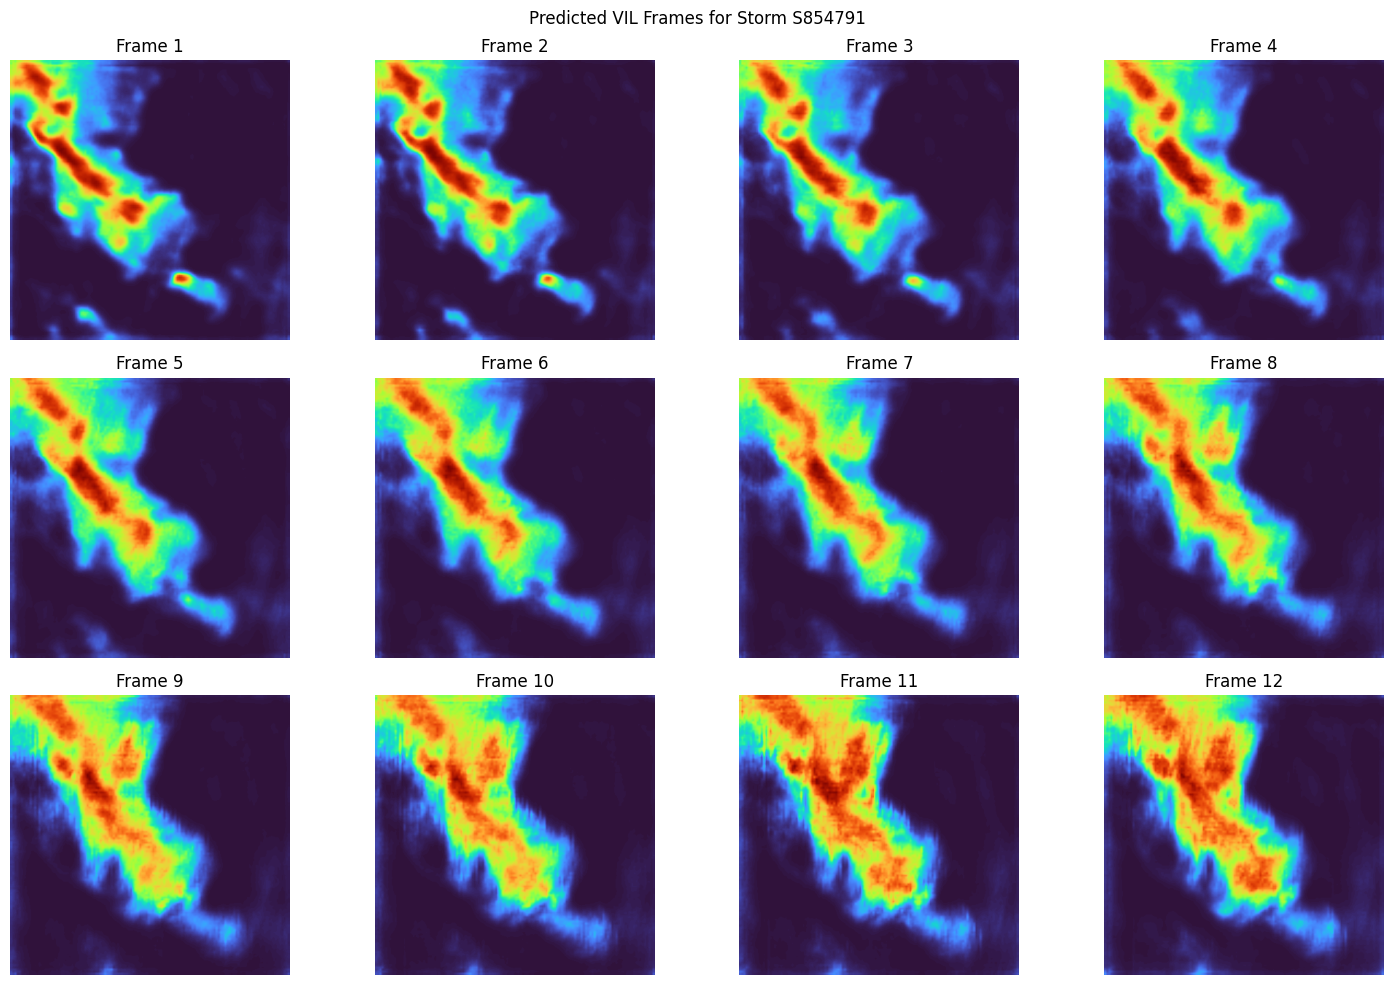

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# Debugging shape
print(f"Initial shape of y_pred_resized: {y_pred_resized.shape}")

# Remove unnecessary singleton dimensions
y_pred_resized = np.squeeze(y_pred_resized)
print(f"Final shape of y_pred_resized: {y_pred_resized.shape}")

# Determine correct indexing
for i, ax in enumerate(axes.flat):
    if i < y_pred_resized.shape[-1]:
        if y_pred_resized.ndim == 3:  # Expected final shape (384, 384, 12)
            frame = y_pred_resized[:, :, i]
        elif y_pred_resized.ndim == 4:  # Handle unexpected shape
            frame = y_pred_resized[:, :, 0, i]
        else:
            raise ValueError(f"Unexpected shape: {y_pred_resized.shape}")

        print(f"Frame {i} shape: {frame.shape}")

        ax.imshow(frame, cmap='turbo')
        ax.set_title(f"Frame {i+1}")

    ax.axis("off")

plt.suptitle(f"Predicted VIL Frames for Storm {event_id}")
plt.tight_layout()
plt.show()


In [46]:
import os
import numpy as np

team_name = "Alberto"  # Replace with your actual team name
predictions_path = "predictions"

# Ensure directory exists
os.makedirs(predictions_path, exist_ok=True)

task1_ids = ['S844398', 'S851491', 'S851111', 'S837416', 'S849444',
             'S843931', 'S858827', 'S856118', 'S849552', 'S854791']

# Create files for Task 1A
for id_ in task1_ids:
    np.save(f"{predictions_path}/{team_name}-task1a-vil-{id_}.npy", np.zeros((384, 384, 12), dtype=np.float32))

# Create files for Task 1B
for id_ in task1_ids:
    np.save(f"{predictions_path}/{team_name}-task1b-vil-{id_}.npy", np.zeros((384, 384, 12), dtype=np.float32))

# Verify files exist and are non-empty
for root, dirs, files in os.walk(predictions_path):
    for file in files:
        file_path = os.path.join(root, file)
        print(f"{file}: {os.path.getsize(file_path)} bytes")

# Check size of predictions directory (Linux/macOS only)
os.system("du -sh predictions")


Alberto-task1b-vil-S844398.npy: 7078016 bytes
Alberto-task1a-vil-S854791.npy: 7078016 bytes
Alberto-task1a-vil-S851111.npy: 7078016 bytes
Alberto-task1a-vil-S837416.npy: 7078016 bytes
Alberto-task1b-vil-S849444.npy: 7078016 bytes
Alberto-task1a-vil-S858827.npy: 7078016 bytes
Alberto-task1a-vil-S843931.npy: 7078016 bytes
Alberto-task1a-vil-S856118.npy: 7078016 bytes
Alberto-task1b-vil-S854791.npy: 7078016 bytes
Alberto-task1a-vil-S844398.npy: 7078016 bytes
Alberto-task1a-vil-S849444.npy: 7078016 bytes
Alberto-task1b-vil-S851491.npy: 7078016 bytes
Alberto-task1b-vil-S849552.npy: 7078016 bytes
Alberto-task1b-vil-S856118.npy: 7078016 bytes
Alberto-task1b-vil-S843931.npy: 7078016 bytes
Alberto-task1b-vil-S851111.npy: 7078016 bytes
Alberto-task1b-vil-S858827.npy: 7078016 bytes
Alberto-task1a-vil-S851491.npy: 7078016 bytes
Alberto-task1b-vil-S837416.npy: 7078016 bytes
Alberto-task1a-vil-S849552.npy: 7078016 bytes


0

In [48]:
import os
import numpy as np

def task1_submission_checker(team_name, prediction_directory):
    """
    Checks that all Task 1 (Task 1A & Task 1B) submission files exist and are in the correct format.
    """

    task1_ids = ['S844398', 'S851491', 'S851111', 'S837416', 'S849444',
                 'S843931', 'S858827', 'S856118', 'S849552', 'S854791']

    # Task 1 requires 2 sets of files: Task 1A and Task 1B
    tags = ["task1a-vil", "task1b-vil"]
    expected_shape = (384, 384, 12)

    for tag in tags:
        for id_ in task1_ids:
            file = f"{prediction_directory.rstrip('/')}/{team_name}-{tag}-{id_}.npy"

            # 1. Check if file exists
            if not os.path.exists(file):
                raise FileNotFoundError(f"ERROR: Missing submission file: {file}")

            # 2. Load file and verify shape & dtype
            try:
                x = np.load(file)
            except Exception as e:
                raise Exception(f"ERROR: Unable to load submission file: {file}\n{e}")

            # 3. Check array shape
            assert x.shape == expected_shape, f"ERROR: Array has wrong shape in {file}, expected {expected_shape}, got {x.shape}"

            # 4. Check dtype
            assert x.dtype == np.float32, f"ERROR: Array has wrong dtype in {file}, expected float32, got {x.dtype}"

    print("Task 1 submission files passed")

# Example usage
team_name = "Alberto"  # Replace with your actual team name
prediction_directory = "predictions"  # Ensure this directory exists

task1_submission_checker(team_name, prediction_directory)


Task 1 submission files passed
